In [1]:
import os
import csv
import cv2
import json
import math
from time import time
import matplotlib.pyplot as plt

In [2]:
import vio_ort_exp as vio_ort
import vio_ort_org as vio_ort_original

In [3]:
# Инициализация параметров
odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)
odometry_org = vio_ort_original.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)
set_dir = '2024_12_15_15_31_8_num_3'
json_files = sorted([f for f in os.listdir(set_dir) if f.endswith('.json')])
start = 1000
count_json = 100

In [4]:
def run_vio(odometry, json_files, start, count_json):
	lat_VIO, lon_VIO, alt_VIO = [], [], []
	lat_GPS, lon_GPS, alt_GPS = [], [], []
	for filename in json_files[start:start + count_json]:
		with open(f'{set_dir}/{filename}', 'r') as file:
			data = json.load(file)
			if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
				img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
				image = cv2.imread(img_path)
				result_vio = odometry.add_trace_pt(image, data)
				lat_VIO.append(result_vio['lat'])
				lon_VIO.append(result_vio['lon'])
				alt_VIO.append(result_vio['alt'] * 1000)
				lat_GPS.append(data['GNRMC'].get('lat', 0.0))
				lon_GPS.append(data['GNRMC'].get('lon', 0.0))
				alt_GPS.append(data['GPS_RAW_INT']['alt'])
	return {
		'lat_VIO': lat_VIO,
		'lon_VIO': lon_VIO,
		'alt_VIO': alt_VIO,
		'lat_GPS': lat_GPS,
		'lon_GPS': lon_GPS,
		'alt_GPS': alt_GPS,
	}

In [5]:
start_time = time()
run_vio(odometry, json_files, start, count_json)
elapsed_time = time() - start_time
print(f"Cache time: {elapsed_time:.2f} seconds")

start_time = time()
results_optimized = run_vio(odometry, json_files, start, count_json)
opt_elapsed_time = time() - start_time
print(f"Optimazed time: {opt_elapsed_time:.2f} seconds")

start_time = time()
results_original = run_vio(odometry_org, json_files, start, count_json)
org_elapsed_time = time() - start_time
print(f"Original time: {org_elapsed_time:.2f} seconds")

Cache time: 10.67 seconds
Optimazed time: 11.99 seconds
Original time: 10.77 seconds


In [6]:
def transform_vio_coords(vio_lon_list, vio_lat_list, gps_lon_list, gps_lat_list):
	gps_lon0 = gps_lon_list[0]
	gps_lat0 = gps_lat_list[0]
	vio_lon0 = vio_lon_list[0]
	vio_lat0 = vio_lat_list[0]

	gps_lon_range = max(gps_lon_list) - min(gps_lon_list)
	gps_lat_range = max(gps_lat_list) - min(gps_lat_list)
	vio_lon_range = max(vio_lon_list) - min(vio_lon_list)
	vio_lat_range = max(vio_lat_list) - min(vio_lat_list)

	scale_for_lon = gps_lon_range / vio_lat_range  # VIO широта -> GPS долгота
	scale_for_lat = gps_lat_range / vio_lon_range  # VIO долгота -> GPS широта

	transformed_lon = [(v_lat - vio_lat0) * scale_for_lon + gps_lon0 for v_lat in vio_lat_list]
	transformed_lat = [-(v_lon - vio_lon0) * scale_for_lat + gps_lat0 for v_lon in vio_lon_list]

	return transformed_lon, transformed_lat

# Применяем трансформацию
transformed_lon_opt, transformed_lat_opt = transform_vio_coords(
	results_optimized['lon_VIO'], results_optimized['lat_VIO'],
	results_optimized['lon_GPS'], results_optimized['lat_GPS']
)

transformed_lon_org, transformed_lat_org = transform_vio_coords(
	results_original['lon_VIO'], results_original['lat_VIO'],
	results_original['lon_GPS'], results_original['lat_GPS']
)

# Обновляем результаты для построения графиков
results_optimized['lon_VIO_transformed'] = transformed_lon_opt
results_optimized['lat_VIO_transformed'] = transformed_lat_opt
results_original['lon_VIO_transformed'] = transformed_lon_org
results_original['lat_VIO_transformed'] = transformed_lat_org

In [7]:
# Функция для вычисления расстояния между двумя точками в метрах
def haversine(lat1, lon1, lat2, lon2):
	R = 6371000  # радиус Земли в метрах
	phi1, phi2 = math.radians(lat1), math.radians(lat2)
	dphi = math.radians(lat2 - lat1)
	dlambda = math.radians(lon2 - lon1)
	a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
	return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [8]:
print("GPS --- VIO org")
print(f"Distance: {haversine(results_original['lat_GPS'][-1], results_original['lon_GPS'][-1], results_original['lat_VIO'][-1], results_original['lon_VIO'][-1]):.4f} meters")

print("GPS --- VIO opt")
print(f"Distance: {haversine(results_original['lat_GPS'][-1], results_original['lon_GPS'][-1], results_optimized['lat_VIO'][-1], results_optimized['lon_VIO'][-1]):.4f} meters")

print("GPS --- VIO org trans")
print(f"Distance: {haversine(results_original['lat_GPS'][-1], results_original['lon_GPS'][-1], results_original['lat_VIO_transformed'][-1], results_original['lon_VIO_transformed'][-1]):.4f} meters")

print("GPS --- VIO opt trans")
print(f"Distance: {haversine(results_original['lat_GPS'][-1], results_original['lon_GPS'][-1], results_optimized['lat_VIO_transformed'][-1], results_optimized['lon_VIO_transformed'][-1]):.4f} meters")


GPS --- VIO org
Distance: 27.8973 meters
GPS --- VIO opt
Distance: 27.8427 meters
GPS --- VIO org trans
Distance: 0.3197 meters
GPS --- VIO opt trans
Distance: 0.3197 meters


In [9]:
# Функция для построения графика с GPS и VIO
def plot_comparison(results_optimized, results_original):
	vio_lat_org = results_original['lat_VIO']
	vio_lon_org = results_original['lon_VIO']
	vio_alt_org = results_original['alt_VIO']

	vio_lat_opt = results_optimized['lat_VIO']
	vio_lon_opt = results_optimized['lon_VIO']
	vio_alt_opt = results_optimized['alt_VIO']

	gps_lat = results_original['lat_GPS']
	gps_lon = results_original['lon_GPS']
	gps_alt = results_original['alt_GPS']

	vio_lat_transformed_opt = results_optimized['lat_VIO_transformed']
	vio_lon_transformed_opt = results_optimized['lon_VIO_transformed']

	vio_lat_transformed_org = results_original['lat_VIO_transformed']
	vio_lon_transformed_org = results_original['lon_VIO_transformed']

	# Построение графиков широты
	plt.figure(figsize=(18, 6))
	plt.subplot(2, 3, 1)
	plt.plot(vio_lat_org, label='Original VIO Latitude', linestyle='--')
	plt.plot(vio_lat_opt, label='Optimized VIO Latitude', linestyle='-.')
	plt.plot(gps_lat, label='GPS Latitude', linestyle='-')
	plt.xlabel('Index')
	plt.ylabel('Latitude')
	plt.title('Latitude Comparison')
	plt.legend()

	# Построение графиков долготы
	plt.subplot(2, 3, 2)
	plt.plot(vio_lon_org, label='Original VIO Longitude', linestyle='--')
	plt.plot(vio_lon_opt, label='Optimized VIO Longitude', linestyle='-.')
	plt.plot(gps_lon, label='GPS Longitude', linestyle='-')
	plt.xlabel('Index')
	plt.ylabel('Longitude')
	plt.title('Longitude Comparison')
	plt.legend()

	# Построение графиков высоты
	plt.subplot(2, 3, 3)
	plt.plot(vio_alt_org, label='Original VIO Altitude', linestyle='--')
	plt.plot(vio_alt_opt, label='Optimized VIO Altitude', linestyle='-.')
	plt.plot(gps_alt, label='GPS Altitude', linestyle='-')
	plt.xlabel('Index')
	plt.ylabel('Altitude (mm)')
	plt.title('Altitude Comparison')
	plt.legend()

	# Построение широты
	plt.subplot(2, 3, 4)
	plt.plot(gps_lat, label='GPS Latitude', linestyle='-')
	plt.plot(vio_lat_transformed_org, label='Original VIO Latitude (transformed)', linestyle='--')
	plt.plot(vio_lat_transformed_opt, label='Optimized VIO Latitude (transformed)', linestyle='-.')
	plt.xlabel('Index')
	plt.ylabel('Latitude')
	plt.title('Latitude Comparison (Transformed)')
	plt.legend()

	# Построение долготы
	plt.subplot(2, 3, 5)
	plt.plot(gps_lon, label='GPS Longitude', linestyle='-')
	plt.plot(vio_lon_transformed_org, label='Original VIO Longitude (transformed)', linestyle='--')
	plt.plot(vio_lon_transformed_opt, label='Optimized VIO Longitude (transformed)', linestyle='-.')
	plt.xlabel('Index')
	plt.ylabel('Longitude')
	plt.title('Longitude Comparison (Transformed)')
	plt.legend()

	# Построение высоты
	plt.subplot(2, 3, 6)
	plt.plot(gps_alt, label='GPS Altitude', linestyle='-')
	plt.plot(vio_alt_org, label='Original VIO Altitude', linestyle='--')
	plt.plot(vio_alt_opt, label='Optimized VIO Altitude', linestyle='-.')
	plt.xlabel('Index')
	plt.ylabel('Altitude (mm)')
	plt.title('Altitude Comparison')
	plt.legend()

	plt.tight_layout()
	plt.show()

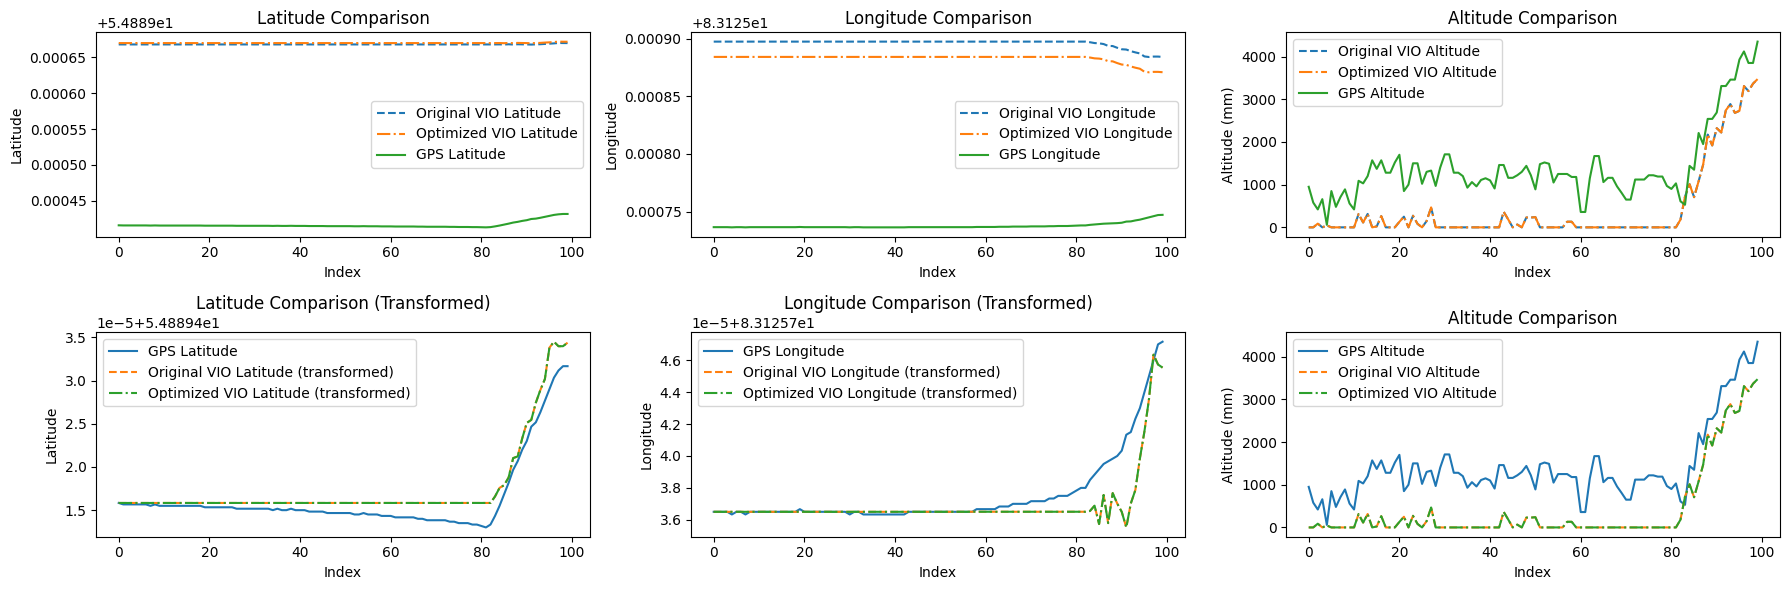

In [10]:
plot_comparison(results_optimized, results_original)

In [11]:
def calculate_aggregated_metrics(results_optimized, results_original):
    metrics = {
        "Original VIO": [],
        "Transformed Original VIO": [],
        "Optimized VIO": [],
        "Transformed Optimized VIO": [],
    }

    for i in range(len(results_original['lat_GPS'])):
        gps_lat, gps_lon = results_original['lat_GPS'][i], results_original['lon_GPS'][i]
        org_lat, org_lon = results_original['lat_VIO'][i], results_original['lon_VIO'][i]
        org_trans_lat, org_trans_lon = results_original['lat_VIO_transformed'][i], results_original['lon_VIO_transformed'][i]
        opt_lat, opt_lon = results_optimized['lat_VIO'][i], results_optimized['lon_VIO'][i]
        opt_trans_lat, opt_trans_lon = results_optimized['lat_VIO_transformed'][i], results_optimized['lon_VIO_transformed'][i]

        metrics["Original VIO"].append(haversine(gps_lat, gps_lon, org_lat, org_lon))
        metrics["Transformed Original VIO"].append(haversine(gps_lat, gps_lon, org_trans_lat, org_trans_lon))
        metrics["Optimized VIO"].append(haversine(gps_lat, gps_lon, opt_lat, opt_lon))
        metrics["Transformed Optimized VIO"].append(haversine(gps_lat, gps_lon, opt_trans_lat, opt_trans_lon))
    
    # Рассчитываем агрегированные данные
    aggregated = {
        "Metric": ["Mean Distance (m)", "Max Distance (m)", "Min Distance (m)", "RMSE (m)"],
    }

    for key, distances in metrics.items():
        mean_distance = sum(distances) / len(distances)
        max_distance = max(distances)
        min_distance = min(distances)
        rmse = math.sqrt(sum(d ** 2 for d in distances) / len(distances))

        aggregated[key] = [mean_distance, max_distance, min_distance, rmse]
    
    return aggregated

In [12]:
def save_aggregated_metrics_to_csv(filename, aggregated_metrics):
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        # Заголовки
        writer.writerow(["Metric"] + list(aggregated_metrics.keys())[1:])
        
        # Данные
        for i in range(len(aggregated_metrics["Metric"])):
            row = [aggregated_metrics["Metric"][i]]
            for key in aggregated_metrics.keys():
                if key != "Metric":
                    row.append(aggregated_metrics[key][i])
            writer.writerow(row)

In [13]:
# Вычисление и сохранение агрегированных метрик
aggregated_metrics = calculate_aggregated_metrics(results_optimized, results_original)
csv_filename_aggregated = "vio_aggregated_metrics.csv"
save_aggregated_metrics_to_csv(csv_filename_aggregated, aggregated_metrics)

print(f"Aggregated metrics saved to {csv_filename_aggregated}.")

Aggregated metrics saved to vio_aggregated_metrics.csv.
